In [1]:
import numpy as np
import matplotlib.pyplot as plt
#%config InlineBackend.figure_format = 'retina'  # For sharper figures, but it takes more time
import scipy as sp
from copy import deepcopy 

from lisatools.utils.constants import *
from lisatools.sensitivity  import AE1SensitivityMatrix
from bbhx.waveformbuild import BBHWaveformFD

# Immports for generating simulated LISA data
import noise_generation as noise_generation
from tools.LISASimulator import LISASimulator
from tools.likelihood import get_dh, get_hh
import tools.likelihood as likelihood

# Imports for MCMC
from tools.time_freq_likelihood import TimeFreqLikelihood
from eryn.ensemble import EnsembleSampler
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.state import State

# Imports for plotting
from chainconsumer import Chain, ChainConsumer, make_sample, Truth
import pandas as pd

No CuPy
No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy or GPU response available.


# Generating Simulated LISA Data

In [2]:
Tobs = YRSID_SI/12
dt = 5.
include_T_channel = False # Set to True if you want to include the T channel in the simulation, otherwise only A and E channels will be included.

wave_gen = BBHWaveformFD(amp_phase_kwargs=dict(run_phenomd=False))
sim = LISASimulator(Tobs=Tobs, dt=dt, wave_gen=wave_gen, include_T_channel=include_T_channel)

m1 = 3e5
m2 = 1.5e5
a1 = 0.2
a2 = 0.4
dist = 8 * PC_SI * 1e9  # distance in Gpc
phi_ref = np.pi/2
f_ref = 0.0
inc = np.pi/3
lam = np.pi/1.
beta = np.pi/4.
psi = np.pi/4.
t_ref = 0.95 * Tobs
#t_ref = round(0.9 * Tobs / dt) * dt  # round to the nearest multiple of dt, to force t_ref to be a part of t_array

parameters = np.array([m1, m2, a1, a2, dist, phi_ref, f_ref, inc, lam, beta, psi, t_ref])

modes = [(2,2), (2,1), (3,3), (3,2), (4,4), (4,3)]
waveform_kwargs = dict(length=1024, direct=False, fill=True, squeeze=False, modes=modes)

data_t, data_f, f_array, t_array, sens_mat = sim(seed = 42, parameters=parameters, waveform_kwargs=waveform_kwargs)

waveform_kwargs.update(freqs=f_array)

In [3]:
print(sim.SNR_optimal()[0])
print(sim.SNR_optimal_lisatools()[0])
print(likelihood.template_snr(data_f, sim.signal_f, AE1SensitivityMatrix(f_array), df=sim.df))

1797.742203231165
1797.7422032309114
1797.6542376148095


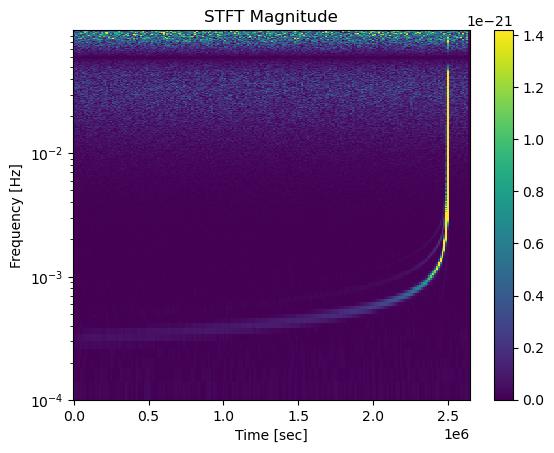

In [4]:
nperseg = 5000
sim.plot_time_frequency(nperseg=nperseg)

# Pre-Merger
Remove the merger from the previously generated simulated LISA data. 

In [5]:
# Pre-Merger Parameters
time_before_merger = 60*60*12
cutoff_time = t_ref - time_before_merger
max_time = t_ref + 60*60*12

"""def pre_merger(gravitational_wave_data_t, time_before_merger, t_ref, t_array):
        cutoff_time = t_ref - time_before_merger
        cutoff_index = np.searchsorted(t_array, cutoff_time)
        data_t_truncated = gravitational_wave_data_t[:, :cutoff_index]
        return data_t_truncated, cutoff_index

data_t, cutoff_index =  pre_merger(data_t, time_before_merger, t_ref, t_array)"""

'def pre_merger(gravitational_wave_data_t, time_before_merger, t_ref, t_array):\n        cutoff_time = t_ref - time_before_merger\n        cutoff_index = np.searchsorted(t_array, cutoff_time)\n        data_t_truncated = gravitational_wave_data_t[:, :cutoff_index]\n        return data_t_truncated, cutoff_index\n\ndata_t, cutoff_index =  pre_merger(data_t, time_before_merger, t_ref, t_array)'

In [6]:
# Check is the likelihood is zero by computing the likelihood of a template with the true parameters with the noise-free signal.
analysis_no_noise = TimeFreqLikelihood(data_t=sim.signal_t[0], wave_gen=wave_gen)
analysis_no_noise.get_stft_of_data()
analysis_no_noise.calculate_time_frequency_likelihood(*parameters, waveform_kwargs=waveform_kwargs)

np.float64(0.0)

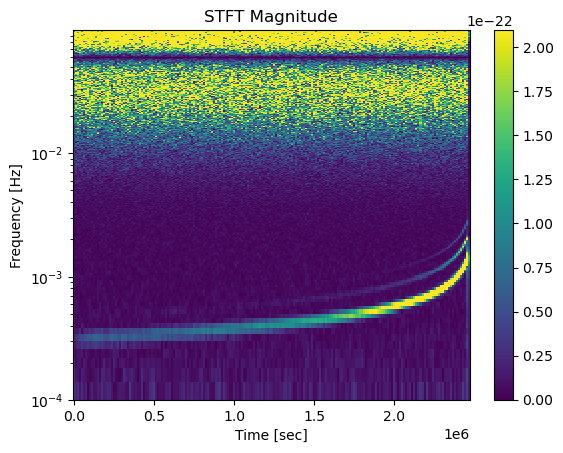

In [7]:
analysis = TimeFreqLikelihood(data_t=data_t, wave_gen=wave_gen, nperseg=nperseg)
analysis.pre_merger(time_before_merger=time_before_merger, t_ref=t_ref, t_array=t_array)
analysis.get_stft_of_data()
analysis.plot_spectrogram()

In [8]:
print("Best likelihood (true parameters)= ", analysis.calculate_time_frequency_likelihood(*parameters, waveform_kwargs=waveform_kwargs))
print("Likelihood of a random template = ", analysis.calculate_time_frequency_likelihood(
    m1 *20* (1 + 1e-7 * np.random.randn(1))[0],
    m2 * (1 + 1e-7 * np.random.randn(1))[0], 
    a1,
    a2,
    dist * 10, 
    phi_ref * (1 + 1e-7 * np.random.randn(1))[0],
    f_ref, 
    inc,
    lam*2,
    beta,
    psi,
    t_ref * (1 + 1e-7 * np.random.randn(1))[0],
    waveform_kwargs=waveform_kwargs
))

Best likelihood (true parameters)=  -40.813569775754665
Likelihood of a random template =  -2593.332277541469


# MCMC

In [9]:
# MCMC parameters
nwalkers = 24
ntemps = 4
ndims = 11
nleaves_max = 1
nsteps = 100
perturb_frac = 0.02

param_labels = [
    r"$M_T$",
    r"$q$",
    r"$a_1$",
    r"$a_2$",
    r"$d_L \, [\mathrm{Mpc}]$",
    r"$\phi_{\mathrm{ref}}$",
    #r"$f_{\mathrm{ref}}$",
    r"$\cos(\iota)$",
    r"$\lambda$",
    r"$\sin(\beta)$",
    r"$\psi$",
    r"$t_{\mathrm{ref}}$"
]

In [10]:
def likelihood(x, freqs, TimeFreqLikelihood_object):
    all_parameters = np.zeros(12)
    mT = x[0]
    q = x[1]
    all_parameters[0] = mT / (1 + q)
    all_parameters[1] = mT * q / (1 + q)
    all_parameters[2] = x[2]
    all_parameters[3] = x[3]
    all_parameters[4] = x[4] * PC_SI * 1e6
    all_parameters[5] = x[5]
    all_parameters[6] = f_ref
    all_parameters[7] = np.arccos(x[6])
    all_parameters[8] = x[7]
    all_parameters[9] = np.arcsin(x[8])
    all_parameters[10] = x[9]
    all_parameters[11] = x[10]

    ll = TimeFreqLikelihood_object.calculate_time_frequency_likelihood(
        *all_parameters,
        waveform_kwargs=dict(
        length=1024, 
        direct=False,
        fill=True,
        squeeze=False,
        freqs=freqs,
        modes=modes
        )
    )
    return ll

In [11]:
priors = {"mbh": ProbDistContainer({
    0 : uniform_dist(1e5, 1e6),                  # mT = m1 + m2
    1 : uniform_dist(0.05, 0.999999),            # q = m2/m1
    2 : uniform_dist(-0.99999999, +0.99999999),  # a1
    3 : uniform_dist(-0.99999999, +0.99999999),  # a2
    4 : uniform_dist(1e3, 10e3),                 # dist in Mpc
    5 : uniform_dist(0.0, 2 * np.pi),            # phi_ref
#   6 : uniform_dist(-1.0, 1.0),                 # f_ref --- IGNORE ---
    6 : uniform_dist(-1, 1),                     # cos(inc)
    7 : uniform_dist(0.0, 2 * np.pi),            # lam
    8 : uniform_dist(-1.0, 1.0),                 # sin(beta)
    9 : uniform_dist(0.0, np.pi),                # psi
    10: uniform_dist(cutoff_time, max_time),     # t_ref
})}

periodic = {"mbh": {5: 2 * np.pi,   # phi_ref
                    7: 2 * np.pi,   # lam
                    9: np.pi  }}    # psi

periodic : dict, optional
Keys are branch_names. Values are dictionaries that have (key: value) pairs as (index to parameter: period). Periodic parameters are treated as having periodic boundary conditions in proposals.

In [12]:
sampler = EnsembleSampler(
    nwalkers,
    ndims,
    likelihood,
    priors,
    args=(f_array, analysis),
    branch_names=["mbh"],
    tempering_kwargs=dict(ntemps = ntemps),
    nleaves_max=dict(mbh = nleaves_max),
    periodic=periodic
)

In [13]:
# Random initialization of walkers from a uniform distribution within the prior bounds
coords = {"mbh": np.zeros((ntemps, nwalkers, nleaves_max, ndims))}
coords["mbh"][:, :, 0] = priors["mbh"].rvs(size=(ntemps, nwalkers))
start_state_rv_from_priors = State({"mbh": coords["mbh"]})

# Uncomment the following to check if the prior is working correctly

# sampler.compute_log_prior(start_state_rv_from_priors.branches_coords)
# log_prior = sampler.compute_log_prior(start_state_rv_from_priors.branches_coords)
# log_like  = sampler.compute_log_like(coords, logp=log_prior)
# print("Log-likelihood:\n", log_like)
# print("\nLog-prior:\n", log_prior)

In [14]:
from scipy.stats import truncnorm

injection_parameters = np.array([m1+m2, m2/m1, a1, a2, dist / (PC_SI * 1e6), phi_ref, np.cos(inc), lam, np.sin(beta), psi, t_ref])

#injection_parameters = np.array([4.5e5, 1.5e5, 0.2, 0.4, 8e3, 2*np.pi-0.4, 0.0, np.pi/3, np.pi/1., np.pi/4., np.pi/4., 0.95 * Tobs])

starting_points = np.zeros(shape=[ntemps, nwalkers, nleaves_max, injection_parameters.shape[0]])

# Perturb the injection parameters to create starting points for the walkers
#perturb_frac = 0.05

non_periodic_params = [0, 1, 2, 3, 4, 6, 7, 8, 10]  # indices of non-periodic parameters

# For non-periodic parameters, draw from a truncated normal distribution around the injection parameters
for i in non_periodic_params:
    low, high = priors["mbh"].priors[i][1].min_val, priors["mbh"].priors[i][1].max_val
    mu = injection_parameters[i]
    sigma = perturb_frac * (high - low)
    a, b = (low - mu) / sigma, (high - mu) / sigma
    starting_points[:, :, :, i] = truncnorm.rvs(a, b, loc=mu, scale=sigma, size=(ntemps, nwalkers, nleaves_max))

# For periodic parameters, draw from a normal distribution around the injection parameters and then wrap around the period
for i, period in periodic["mbh"].items():
    sigma = perturb_frac * period
    perturbed = injection_parameters[i] + sigma * np.random.randn(ntemps, nwalkers, nleaves_max)
    starting_points[:, :, :, i] = np.mod(perturbed, period)

# For t_ref (index 11): uniform draw
#starting_points[:, :, :, 11] = np.random.uniform(low=priors["mbh"].priors[11][1].min_val, high=priors["mbh"].priors[11][1].max_val, size=(ntemps, nwalkers, nleaves_max))

starting_state = State({"mbh": starting_points})

In [15]:
# Uncomment the following to check if the starting points are working correctly

log_prior = sampler.compute_log_prior(starting_state.branches_coords)
print("\nLog-prior:\n", log_prior)
#log_like  = sampler.compute_log_like(starting_state.branches_coords, logp=log_prior)
#print("Log-likelihood:\n", log_like)



Log-prior:
 [[-41.72365123 -41.72365123 -41.72365123 -41.72365123 -41.72365123
  -41.72365123 -41.72365123 -41.72365123 -41.72365123 -41.72365123
  -41.72365123 -41.72365123 -41.72365123 -41.72365123 -41.72365123
  -41.72365123 -41.72365123 -41.72365123 -41.72365123 -41.72365123
  -41.72365123 -41.72365123 -41.72365123 -41.72365123]
 [-41.72365123 -41.72365123 -41.72365123 -41.72365123 -41.72365123
  -41.72365123 -41.72365123 -41.72365123 -41.72365123 -41.72365123
  -41.72365123 -41.72365123 -41.72365123 -41.72365123 -41.72365123
  -41.72365123 -41.72365123 -41.72365123 -41.72365123 -41.72365123
  -41.72365123 -41.72365123 -41.72365123 -41.72365123]
 [-41.72365123 -41.72365123 -41.72365123 -41.72365123 -41.72365123
  -41.72365123 -41.72365123 -41.72365123 -41.72365123 -41.72365123
  -41.72365123 -41.72365123 -41.72365123 -41.72365123 -41.72365123
  -41.72365123 -41.72365123 -41.72365123 -41.72365123 -41.72365123
  -41.72365123 -41.72365123 -41.72365123 -41.72365123]
 [-41.72365123 -41

Mean of parameter 8 is 0.7071067811865475
Sigma of parameter 8 is 0.04


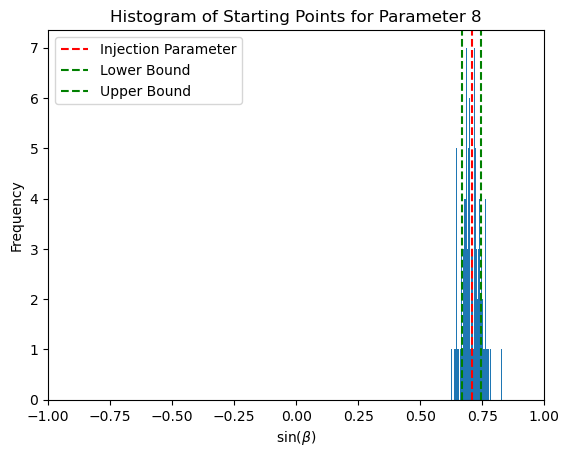

In [16]:
# Plot the histogram of the starting points
index_for_histogram = 8

size_of_prior = priors["mbh"].priors[index_for_histogram][1].max_val - priors["mbh"].priors[index_for_histogram][1].min_val
print("Mean of parameter", index_for_histogram, "is", injection_parameters[index_for_histogram])
print("Sigma of parameter", index_for_histogram, "is", perturb_frac * size_of_prior)

plt.hist(starting_points[:, :, :, index_for_histogram].flatten(), bins=50)
plt.axvline(injection_parameters[index_for_histogram], color='r', linestyle='--', label='Injection Parameter')
plt.axvline(injection_parameters[index_for_histogram] - perturb_frac * size_of_prior, color='g', linestyle='--', label='Lower Bound')
plt.axvline(injection_parameters[index_for_histogram] + perturb_frac * size_of_prior, color='g', linestyle='--', label='Upper Bound')
plt.title(f'Histogram of Starting Points for Parameter {index_for_histogram}')
plt.xlabel(param_labels[index_for_histogram])
plt.xlim(priors["mbh"].priors[index_for_histogram][1].min_val, priors["mbh"].priors[index_for_histogram][1].max_val)
plt.ylabel('Frequency')
plt.legend(loc='upper left')
plt.show()

In [17]:
sampler.run_mcmc(starting_state, nsteps=20, progress=True)

100%|██████████| 20/20 [08:10<00:00, 24.51s/it]


In [18]:
# Uncomment the following to save or load the chain

#sampler.get_chain()["mbh"]
#np.save("chain.npy", sampler.get_chain()["mbh"])
#arr = np.load("chain.npy")

In [19]:
#log_like_samples = sampler.get_log_like()
#log_like_samples
#log_like_samples[:,:,0]

Parameter $q$ in chain MCMC Results is not constrained
Parameter $\phi_{\mathrm{ref}}$ in chain MCMC Results is not constrained
Parameter $\cos(\iota)$ in chain MCMC Results is not constrained
Parameter $\lambda$ in chain MCMC Results is not constrained
Parameter $\sin(\beta)$ in chain MCMC Results is not constrained
Parameter $\psi$ in chain MCMC Results is not constrained
Parameter $t_{\mathrm{ref}}$ in chain MCMC Results is not constrained


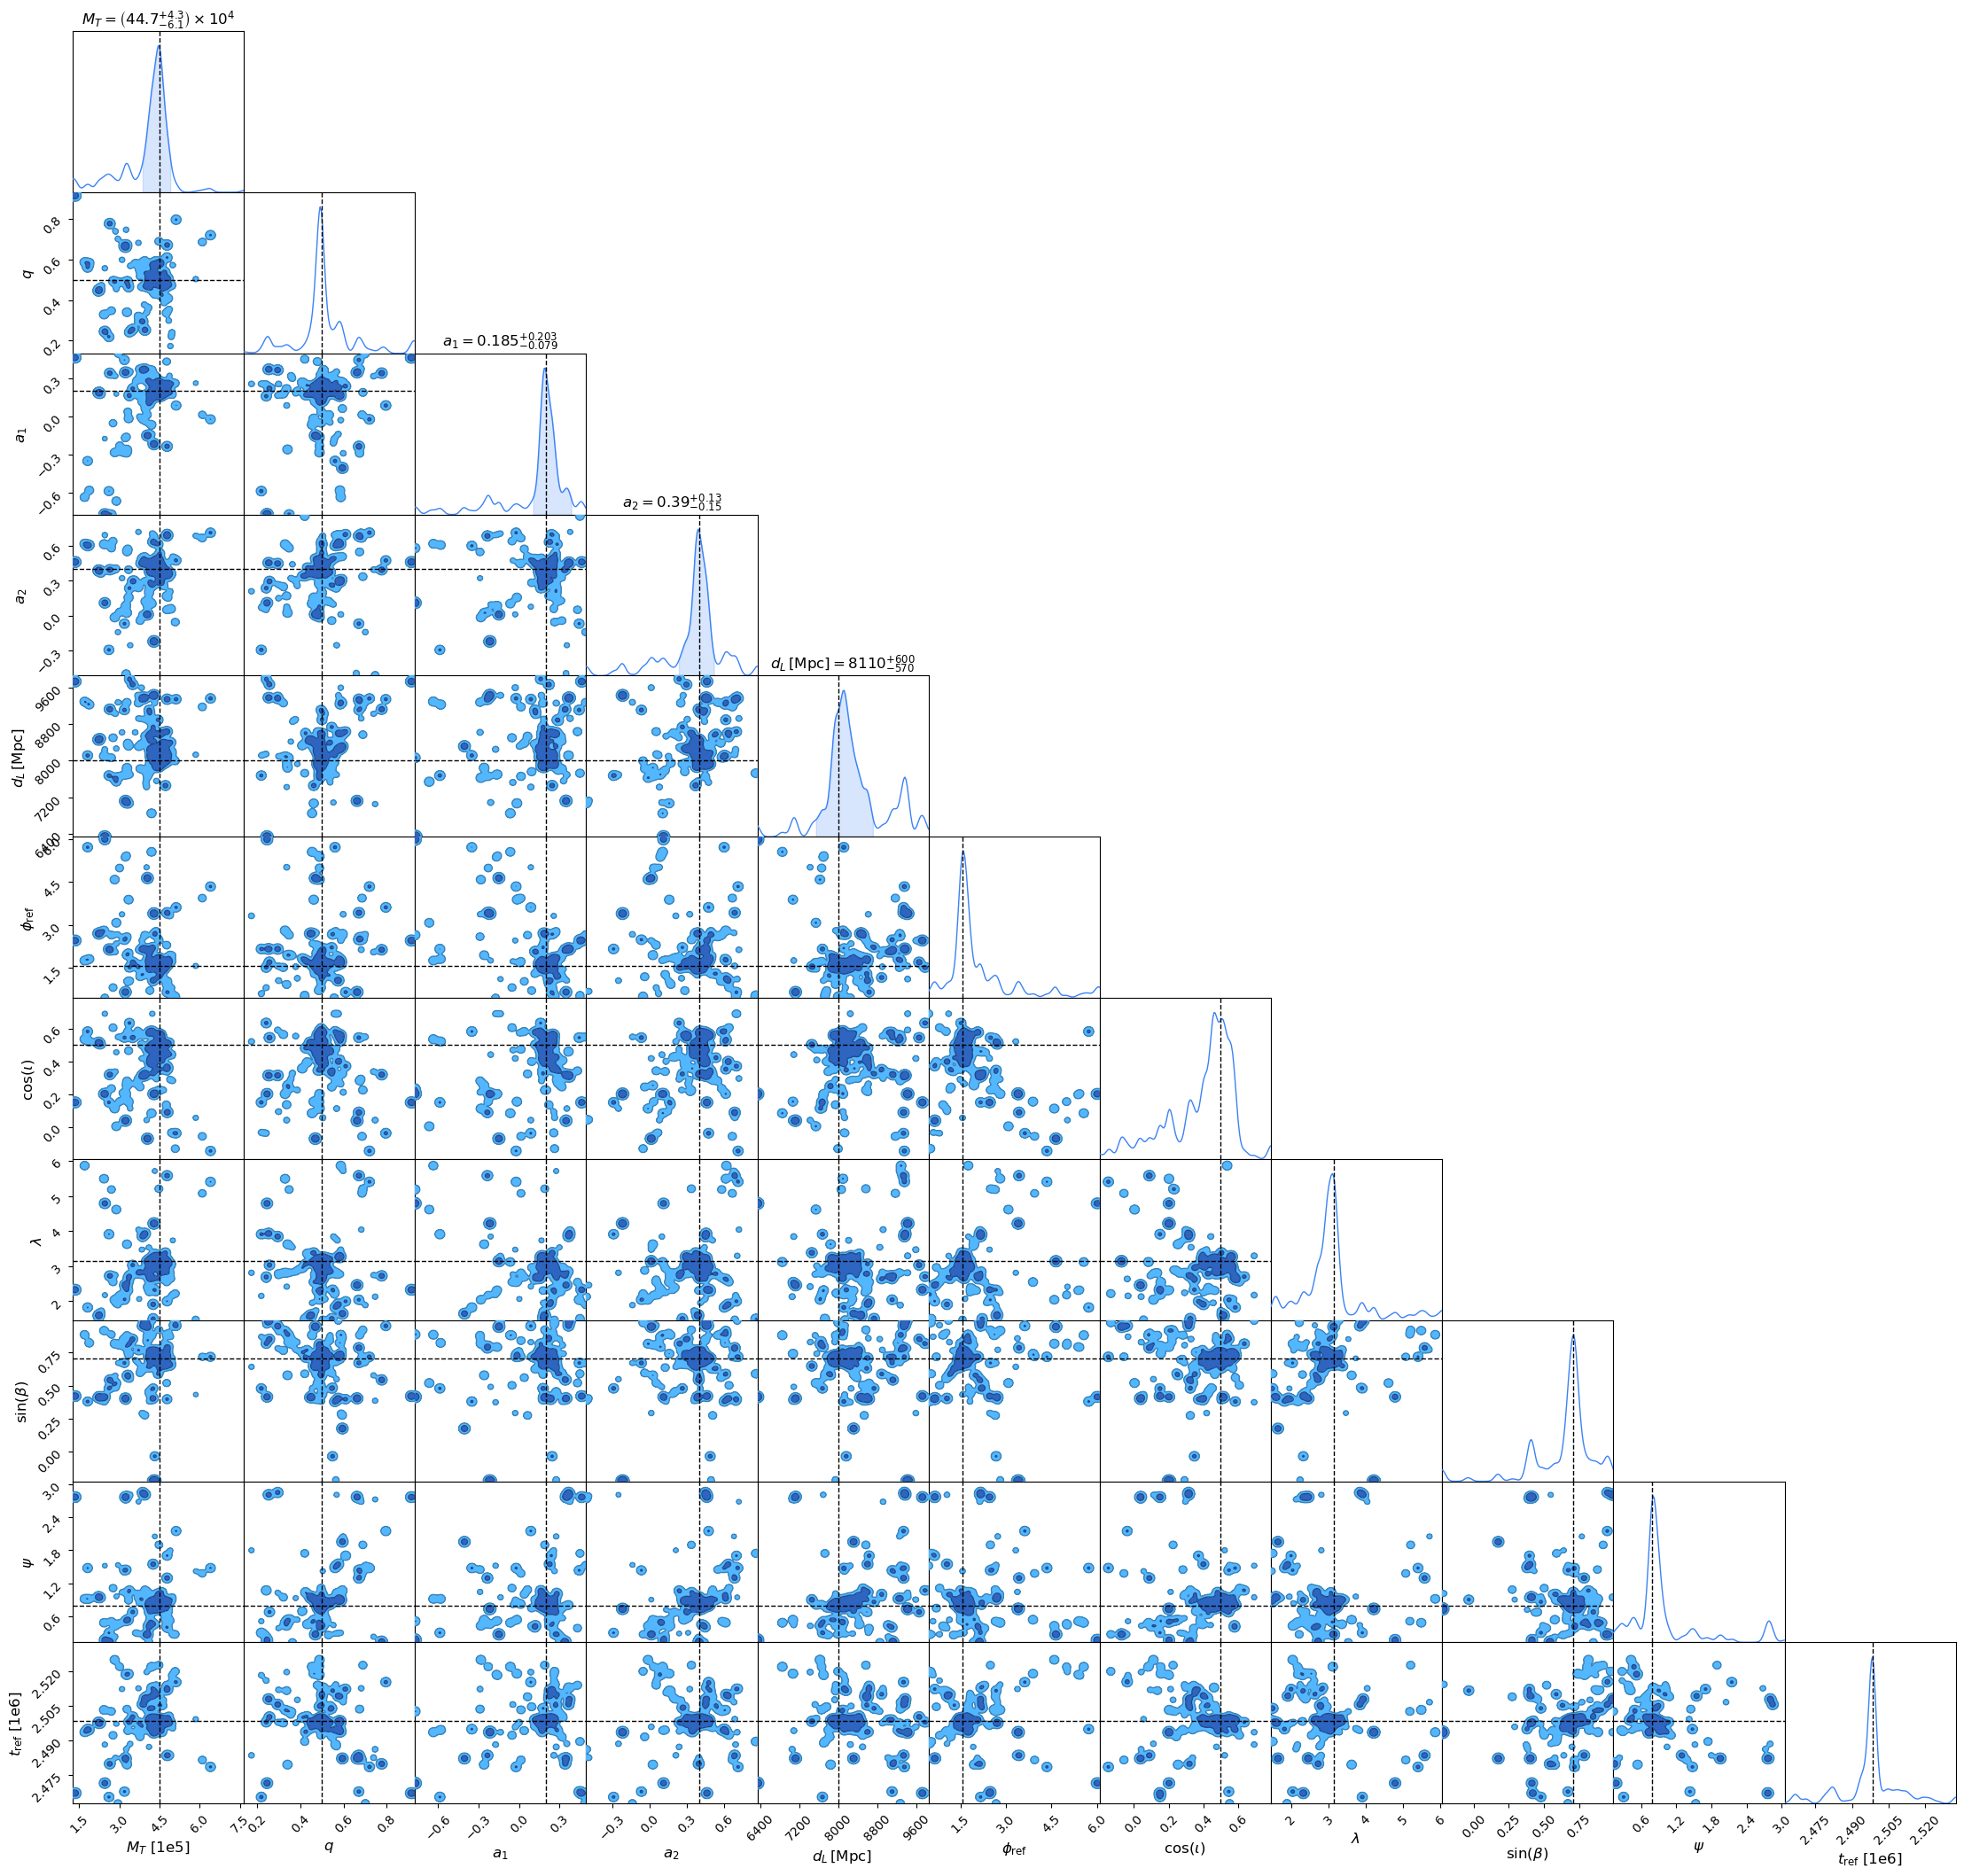

In [20]:
from chainconsumer import Chain, ChainConsumer, make_sample, Truth
import pandas as pd

mcmc_results = sampler.get_chain()["mbh"]

samples = mcmc_results[:, 0].reshape(-1, 11)
df = pd.DataFrame(samples, columns=param_labels)

#df.drop(columns=[r"$f_{\mathrm{ref}}$"], inplace=True)  # Remove f_ref column if not needed
# df.to_pickle("mcmc_samples.pkl")

#burn_in_2 = 5000                           # Remove burn-in samples if needed
#df_post_burnin = df.iloc[burn_in_2:]

injection_parameters = np.array([m1+m2, m2/m1, a1, a2, dist / (PC_SI * 1e6), phi_ref, np.cos(inc), lam, np.sin(beta), psi, t_ref])
c = ChainConsumer() 
c.add_chain(Chain(samples=df, name="MCMC Results"))
c.add_truth(Truth(location={r"$M_T$"                      : injection_parameters[0],
                            r"$q$"                        : injection_parameters[1], 
                            r"$a_1$"                      : injection_parameters[2],
                            r"$a_2$"                      : injection_parameters[3],
                            r"$d_L \, [\mathrm{Mpc}]$"    : injection_parameters[4],
                            r"$\phi_{\mathrm{ref}}$"      : injection_parameters[5],
                            #r"$f_{\mathrm{ref}}$"         : injection_parameters[6],
                            r"$\cos(\iota)$"              : injection_parameters[6],
                            r"$\lambda$"                  : injection_parameters[7],
                            r"$\sin(\beta)$"              : injection_parameters[8],
                            r"$\psi$"                     : injection_parameters[9],
                            r"$t_{\mathrm{ref}}$"         : injection_parameters[10]} ))
fig = c.plotter.plot()

In [21]:
"""mcmc_results_transformed = deepcopy(mcmc_results)
mcmc_results_transformed[:,:,:,:,6] = np.arccos(mcmc_results_transformed[:,:,:,:,6])  # Transform cos(inc) to inc
mcmc_results_transformed[:,:,:,:,8] = np.arcsin(mcmc_results_transformed[:,:,:,:,8])  # Transform sin(beta) to beta

param_labels_transformed = [
    r"$M_T$",
    r"$q$",
    r"$a_1$",
    r"$a_2$",
    r"$d_L \, [\mathrm{Mpc}]$",
    r"$\phi_{\mathrm{ref}}$",
    #r"$f_{\mathrm{ref}}$",
    r"$\iota$",
    r"$\lambda$",
    r"$\beta$",
    r"$\psi$",
    r"$t_{\mathrm{ref}}$"
]
samples_transformed = mcmc_results_transformed[:, 0].reshape(-1, 11)
df_transformed = pd.DataFrame(samples_transformed, columns=param_labels_transformed)
c_transformed = ChainConsumer()
c_transformed.add_chain(Chain(samples=df_transformed, name="MCMC Results Transformed"))
c_transformed.add_truth(Truth(location={r"$M_T$"                      : injection_parameters[0],
                            r"$q$"                        : injection_parameters[1], 
                            r"$a_1$"                      : injection_parameters[2],
                            r"$a_2$"                      : injection_parameters[3],
                            r"$d_L \, [\mathrm{Mpc}]$"    : injection_parameters[4],
                            r"$\phi_{\mathrm{ref}}$"      : injection_parameters[5],
                            #r"$f_{\mathrm{ref}}$"         : injection_parameters[6],
                            r"\iota$"              : injection_parameters[6],
                            r"$\lambda$"                  : injection_parameters[7],
                            r"$\beta$"              : injection_parameters[8],
                            r"$\psi$"                     : injection_parameters[9],
                            r"$t_{\mathrm{ref}}$"         : injection_parameters[10]} ))
fig_transformed = c_transformed.plotter.plot()"""

<>:1: SyntaxWarning: invalid escape sequence '\,'
<>:1: SyntaxWarning: invalid escape sequence '\,'
/var/folders/zq/6x2qbk397t13zwgl047mwbkm0000gn/T/ipykernel_11646/4261558548.py:1: SyntaxWarning: invalid escape sequence '\,'
  """mcmc_results_transformed = deepcopy(mcmc_results)


'mcmc_results_transformed = deepcopy(mcmc_results)\nmcmc_results_transformed[:,:,:,:,6] = np.arccos(mcmc_results_transformed[:,:,:,:,6])  # Transform cos(inc) to inc\nmcmc_results_transformed[:,:,:,:,8] = np.arcsin(mcmc_results_transformed[:,:,:,:,8])  # Transform sin(beta) to beta\n\nparam_labels_transformed = [\n    r"$M_T$",\n    r"$q$",\n    r"$a_1$",\n    r"$a_2$",\n    r"$d_L \\, [\\mathrm{Mpc}]$",\n    r"$\\phi_{\\mathrm{ref}}$",\n    #r"$f_{\\mathrm{ref}}$",\n    r"$\\iota$",\n    r"$\\lambda$",\n    r"$\x08eta$",\n    r"$\\psi$",\n    r"$t_{\\mathrm{ref}}$"\n]\nsamples_transformed = mcmc_results_transformed[:, 0].reshape(-1, 11)\ndf_transformed = pd.DataFrame(samples_transformed, columns=param_labels_transformed)\nc_transformed = ChainConsumer()\nc_transformed.add_chain(Chain(samples=df_transformed, name="MCMC Results Transformed"))\nc_transformed.add_truth(Truth(location={r"$M_T$"                      : injection_parameters[0],\n                            r"$q$"             

Text(0.5, 0, 'Step')

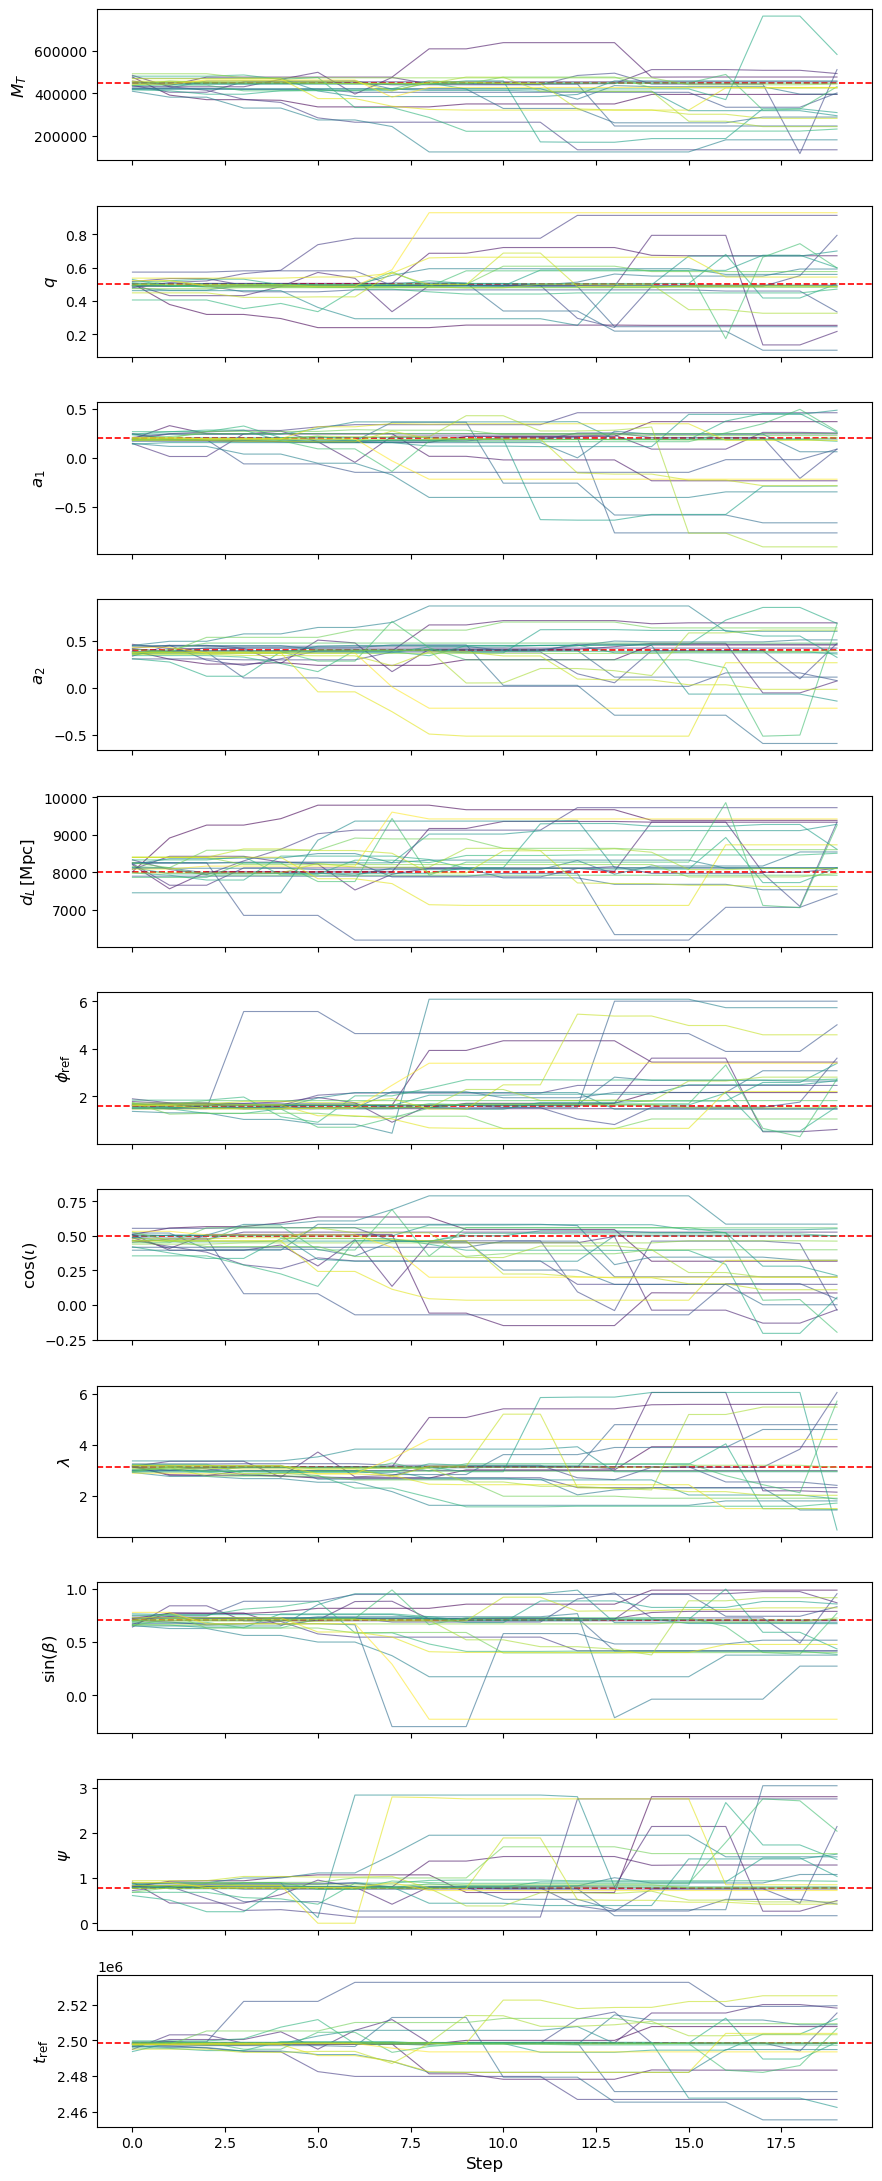

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

plotting_walkers_range = nwalkers
colors = cm.viridis(np.linspace(0, 1, plotting_walkers_range))

fig, ax = plt.subplots(ndims, 1, sharex=True, figsize=(10, 2.5 * ndims))
fig.subplots_adjust(hspace=0.3)


for i in range(ndims):
    ax[i].axhline(injection_parameters[i], color='red', linestyle='--', linewidth=1.2, label="True value")
    for walk in range(plotting_walkers_range):
        ax[i].plot(mcmc_results[:, 0, walk, :, i].flatten(), color=colors[walk], alpha=0.6, linewidth=0.8)
    #ax[i].axhline(starting_points[0, walk, :, i], color='blue', linestyle='--', linewidth=1.2, label="Starting point of the last walker")

    ax[i].set_ylabel(param_labels[i], fontsize=12)
    #ax[i].legend(loc='upper right', fontsize=10)

ax[-1].set_xlabel("Step", fontsize=12)


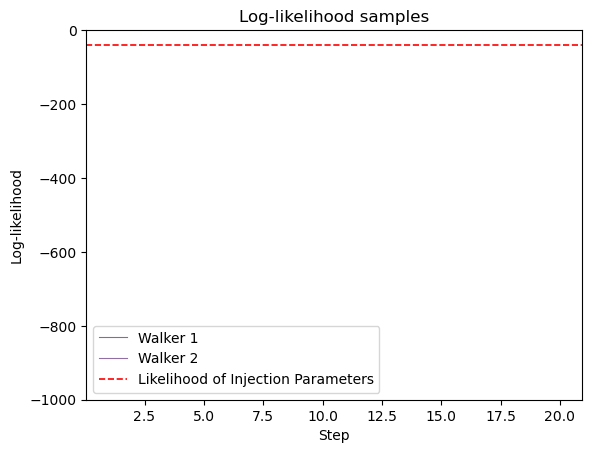

In [24]:
log_like_samples = sampler.get_log_like() 

for i in range(2):
    plt.plot(np.arange(1, log_like_samples.shape[0]+1), log_like_samples[:,0,i], label=f"Walker {i+1}", color=colors[i], alpha=0.6, linewidth=0.8)

plt.axhline(analysis.calculate_time_frequency_likelihood(*parameters, waveform_kwargs=waveform_kwargs)  , 
            color='red', linestyle='--', linewidth=1.2, label="Likelihood of Injection Parameters")

plt.title("Log-likelihood samples")
plt.xlabel("Step")
plt.ylabel("Log-likelihood")
#plt.xticks(nsteps)
plt.ylim(-1000, 0)
plt.legend()


In [23]:
import os
os.system("say 'Computation is done!'")

0

In [ ]:
"""
nwalkers_2 = 50
ntemps_2 = 4
ndims_2 = 12
nleaves_max_2 = 1
nsteps_2 = 500

sampler_2 = EnsembleSampler(
    nwalkers_2,
    ndims_2,
    likelihood,
    priors,
    args=(f_array, analysis),
    branch_names=["mbh"],
    tempering_kwargs=dict(ntemps=ntemps_2),
    nleaves_max=dict(mbh=nleaves_max_2),
    periodic=periodic
)

coords_2 = {"mbh": np.zeros((ntemps_2, nwalkers_2, nleaves_max_2, ndims_2))}
coords_2["mbh"][:, :, 0] = priors["mbh"].rvs(size=(ntemps_2, nwalkers_2))
start_state_rv_from_priors_2 = State({"mbh": coords_2["mbh"]})
sampler_2.run_mcmc(start_state_rv_from_priors_2, nsteps=nsteps_2, progress=True)

samples_2 = sampler_2.get_chain()["mbh"][:, 0].reshape(-1, 12)
df_2 = pd.DataFrame(samples_2, columns=['mT',
                                        'q',
                                        'a1',
                                        'a2',
                                        'dist',
                                        'phi_ref',
                                        'f_ref',
                                        'inc',
                                        'lam',
                                        'beta',
                                        'psi',
                                        't_ref'])
c_2 = ChainConsumer()
c_2.add_chain(Chain(samples=df_2, name="An Example Contour"))
c_2.add_truth(Truth(location={"mT"      : injection_parameters[0],
                            "q"         : injection_parameters[1], 
                            "a1"        : injection_parameters[2],
                            "a2"        : injection_parameters[3],
                            "dist"      : injection_parameters[4],
                            "phi_ref"   : injection_parameters[5],
                            "f_ref"     : injection_parameters[6],
                            "inc"       : injection_parameters[7],
                            "lam"       : injection_parameters[8],
                            "beta"      : injection_parameters[9],
                            "psi"       : injection_parameters[10],
                            "t_ref"     : injection_parameters[11]}))
fig_2 = c_2.plotter.plot()

df_2.to_pickle("mcmc_samples_2.pkl")
"""

'\nnwalkers_2 = 50\nntemps_2 = 4\nndims_2 = 12\nnleaves_max_2 = 1\nnsteps_2 = 500\n\nsampler_2 = EnsembleSampler(\n    nwalkers_2,\n    ndims_2,\n    likelihood,\n    priors,\n    args=(f_array, analysis),\n    branch_names=["mbh"],\n    tempering_kwargs=dict(ntemps=ntemps_2),\n    nleaves_max=dict(mbh=nleaves_max_2),\n    periodic=periodic\n)\n\ncoords_2 = {"mbh": np.zeros((ntemps_2, nwalkers_2, nleaves_max_2, ndims_2))}\ncoords_2["mbh"][:, :, 0] = priors["mbh"].rvs(size=(ntemps_2, nwalkers_2))\nstart_state_rv_from_priors_2 = State({"mbh": coords_2["mbh"]})\nsampler_2.run_mcmc(start_state_rv_from_priors_2, nsteps=nsteps_2, progress=True)\n\nsamples_2 = sampler_2.get_chain()["mbh"][:, 0].reshape(-1, 12)\ndf_2 = pd.DataFrame(samples_2, columns=[\'mT\',\n                                        \'q\',\n                                        \'a1\',\n                                        \'a2\',\n                                        \'dist\',\n                                        

In [ ]:
"""
# read from pickle
injection_parameters = np.array([m1+m2, m2/m1, a1, a2, dist / (PC_SI * 1e6), phi_ref, f_ref, inc, lam, beta, psi, t_ref])

df = pd.read_pickle("mcmc_samples.pkl")

burn_in_1 = 2500 
df_post_burnin = df.iloc[burn_in_1:]

c_1 = ChainConsumer()
c_1.add_chain(Chain(samples=df_post_burnin, name="An Example Contour"))
c_1.add_truth(Truth(location={"mT"      : injection_parameters[0],
                            "q"         : injection_parameters[1], 
                            "a1"        : injection_parameters[2],
                            "a2"        : injection_parameters[3],
                            "dist"      : injection_parameters[4],
                            "phi_ref"   : injection_parameters[5],
                            "f_ref"     : injection_parameters[6],
                            "inc"       : injection_parameters[7],
                            "lam"       : injection_parameters[8],
                            "beta"      : injection_parameters[9],
                            "psi"       : injection_parameters[10],
                            "t_ref"     : injection_parameters[11]}))
fig_1 = c_1.plotter.plot()
"""

'\n# read from pickle\ninjection_parameters = np.array([m1+m2, m2/m1, a1, a2, dist / (PC_SI * 1e6), phi_ref, f_ref, inc, lam, beta, psi, t_ref])\n\ndf = pd.read_pickle("mcmc_samples.pkl")\n\nburn_in_1 = 2500 \ndf_post_burnin = df.iloc[burn_in_1:]\n\nc_1 = ChainConsumer()\nc_1.add_chain(Chain(samples=df_post_burnin, name="An Example Contour"))\nc_1.add_truth(Truth(location={"mT"      : injection_parameters[0],\n                            "q"         : injection_parameters[1], \n                            "a1"        : injection_parameters[2],\n                            "a2"        : injection_parameters[3],\n                            "dist"      : injection_parameters[4],\n                            "phi_ref"   : injection_parameters[5],\n                            "f_ref"     : injection_parameters[6],\n                            "inc"       : injection_parameters[7],\n                            "lam"       : injection_parameters[8],\n                            "beta"      :